In [1]:
import re
from bisect import bisect
from optparse import OptionParser

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapely.geometry as geo
from sklearn.neighbors import KDTree
from tqdm import tqdm

In [2]:
mz_dir = "/home/tchervec/Documents/projects/sccer_ja/data/00_raw/microcensus"
statpop_dir = "/home/tchervec/Documents/projects/sccer_ja/data/00_raw/statpop"
input_file = "/home/tchervec/Documents/projects/sccer_ja/data/10_interim/2020/plan_features.csv"


# Load in plan features
features = pd.read_csv(filepath_or_buffer=input_file, sep="\t")
features = features.query('longest_stop_s >= 0')
print(features.head(3))
#print("Features - number of agents", len(features["mzPersonId"]), len(features["mzPersonId"].unique()))

   agentId  age sex  mzHeadId  mzPersonId  statpopHouseholdId  \
0  1000206   31   f    240866      262365     201202300013092   
1  1000207   44   m    240866      340535     201202300013092   
2  1000795   44   f    390494      312001     201202300043306   

   statpopPersonId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  ...  \
0  201240010734941         48262.0              25200.0     3005.726459  ...   
1  201240011153461         20692.0              -8893.0    27127.377542  ...   
2  201240010775095         46858.0              13021.0    12063.646037  ...   

   driven_s_[68400.0;72000.0]  distance_m_[68400.0;72000.0]  \
0                         0.0                      0.000000   
1                      3600.0                   1355.148445   
2                      3393.0                      0.000000   

   driven_s_[72000.0;75600.0]  distance_m_[72000.0;75600.0]  \
0                         0.0                      0.000000   
1                      3600.0          

In [3]:
# Add annual car km driven
df_mz_vehicles = (pd.read_csv("{dir}/fahrzeuge.csv".format(dir=mz_dir), encoding='latin')
                  .rename({"HHNR" : "mzPersonId",
                           "f30900_31700" : "year_km",
                           "f30700_hpnr1": "driver_1",
                           "f30700_hpnr2": "driver_2",
                           "f30700_hpnr3": "driver_3",
                           "f30700_hpnr4": "driver_4",
                           "f30700_hpnr5": "driver_5",
                           }, axis=1)
                  )[["mzPersonId", "year_km",
                     "driver_1", "driver_2", "driver_3", "driver_4", "driver_5"]]

df_mz_vehicles["year_km"] = df_mz_vehicles["year_km"].replace([-97, -98, -99], -1)
df_mz_vehicles = df_mz_vehicles.replace([-97, -98, -99], 100)
df_mz_vehicles = (df_mz_vehicles
                  .sort_values(["driver_1", "driver_2", "driver_3", "driver_4", "driver_5"], ascending=True)
                  .groupby("mzPersonId", as_index=False).first()
                  )[["mzPersonId", "year_km"]]
print(df_mz_vehicles.head(3))

features = pd.merge(features, df_mz_vehicles, on='mzPersonId', how='left')
features = features.query("year_km >= 0")
print(features.head(3))

   mzPersonId  year_km
0      100004    13000
1      100010     5000
2      100021     5000
   agentId  age sex  mzHeadId  mzPersonId  statpopHouseholdId  \
1  1000207   44   m    240866      340535     201202300013092   
2  1000795   44   f    390494      312001     201202300043306   
3  1000799   40   m    390494      110059     201202300043306   

   statpopPersonId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  ...  \
1  201240011153461         20692.0              -8893.0    27127.377542  ...   
2  201240010775095         46858.0              13021.0    12063.646037  ...   
3  201240015752790         37934.0              24603.0     4808.971777  ...   

   distance_m_[68400.0;72000.0]  driven_s_[72000.0;75600.0]  \
1                   1355.148445                      3600.0   
2                      0.000000                         0.0   
3                      0.000000                         0.0   

   distance_m_[72000.0;75600.0]  driven_s_[75600.0;79200.0]  \
1         

In [4]:
# Add income info
df_mz_households = (pd.read_csv("{dir}/haushalte.csv".format(dir=mz_dir), encoding='latin')[["HHNR", "F20601"]]
                    .rename({"HHNR" : "mzPersonId",
                             "F20601" : "income"}, axis=1))
features = pd.merge(features, df_mz_households, on='mzPersonId', how='left')
features = features.query("income >= 0")
print(features.head(3))

   agentId  age sex  mzHeadId  mzPersonId  statpopHouseholdId  \
0  1000207   44   m    240866      340535     201202300013092   
1  1000795   44   f    390494      312001     201202300043306   
2  1000799   40   m    390494      110059     201202300043306   

   statpopPersonId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  ...  \
0  201240011153461         20692.0              -8893.0    27127.377542  ...   
1  201240010775095         46858.0              13021.0    12063.646037  ...   
2  201240015752790         37934.0              24603.0     4808.971777  ...   

   driven_s_[72000.0;75600.0]  distance_m_[72000.0;75600.0]  \
0                      3600.0                      4.407407   
1                         0.0                      0.000000   
2                         0.0                      0.000000   

   driven_s_[75600.0;79200.0]  distance_m_[75600.0;79200.0]  \
0                      3600.0                    161.048309   
1                         0.0          

In [5]:
# Add home location agglo type

matsim_trips = '/home/tchervec/Documents/projects/sccer_ja/data/10_interim/2020/trips.csv'

df_trips_matsim = pd.read_csv(filepath_or_buffer=matsim_trips, sep=";")
df_trips_matsim = df_trips_matsim[~df_trips_matsim["person_id"].str.contains("freight")]
print(df_trips_matsim.head(3))

  person_id  person_trip_id      origin_x      origin_y  destination_x  \
0   4230602               0  2.631443e+06  1.218070e+06   2.630459e+06   
2   5964131               0  2.687168e+06  1.206241e+06   2.691716e+06   
3   8107463               0  2.499512e+06  1.117491e+06   2.499790e+06   

   destination_y  start_time  travel_time  network_distance mode  \
0   1.218239e+06      7705.0        165.0       1199.253358  car   
2   1.207463e+06      8694.0        533.0       5638.906158  car   
3   1.116151e+06      9473.0        416.0       1941.078133  car   

  preceedingPurpose followingPurpose  returning  crowfly_distance  
0              home             work      False        998.299643  
2              home             work      False       4708.446541  
3              home             work      False       1367.935360  


In [6]:
# load municipality shapefile
print("Loading municipality shapefile...")
mun_shp = '/home/tchervec/Documents/projects/sccer_ja/data/00_raw/shp/g1g18.shp'
df_municipalities = gpd.read_file(mun_shp, encoding = "latin1").to_crs('EPSG:2056')
df_municipalities = df_municipalities[["GMDNR", "geometry"]].rename({"GMDNR":"municipality_id"}, axis=1)
print(df_municipalities.head(3))

Loading municipality shapefile...
   municipality_id                                           geometry
0                1  POLYGON ((2678219.000 1235219.000, 2678439.000...
1                2  POLYGON ((2678219.000 1235219.000, 2677940.000...
2                3  POLYGON ((2675803.000 1241039.000, 2675748.000...


In [7]:
# load spatial structure data
print("Loading canton and municipality type data...")
spatial_structure = '/home/tchervec/Documents/projects/sccer_ja/data/00_raw/spatial_structure_2018.xlsx'
df_municipality_types = pd.read_excel(spatial_structure,
                                      names=["municipality_id", "agglo_type"],
                                      usecols=[0, 17],
                                      skiprows=6,
                                      nrows=2229,
                                      )
print(df_municipality_types.head(3))

Loading canton and municipality type data...
   municipality_id  agglo_type
0                1           1
1                2           1
2                3           1


In [8]:
# function definitions

def to_gpd(df, x="x", y="y", crs="EPSG:2056"):
    df["geometry"] = [
        geo.Point(*coord) for coord in tqdm(
            zip(df[x], df[y]), total=len(df),
            desc="Converting coordinates"
        )]
    df = gpd.GeoDataFrame(df)
    df.crs = crs

    if not crs == "EPSG:2056":
        df = df.to_crs("EPSG:2056")

    return df


def impute(df_points, df_zones, point_id_field, zone_id_field, fix_by_distance=True, chunk_size=10000):
    assert(type(df_points) == gpd.GeoDataFrame)
    assert(type(df_zones) == gpd.GeoDataFrame)

    assert(point_id_field in df_points.columns)
    assert(zone_id_field in df_zones.columns)
    assert(not zone_id_field in df_points.columns)

    df_original = df_points
    df_points = df_points[[point_id_field, "geometry"]]
    df_zones = df_zones[[zone_id_field, "geometry"]]

    #print("Imputing %d zones into %d points by spatial join..." % (len(df_zones), len(df_points)))

    result = []
    chunk_count = max(1, int(len(df_points) / chunk_size))
    for chunk in tqdm(np.array_split(df_points, chunk_count), total=chunk_count):
        result.append(gpd.sjoin(df_zones, chunk, op="contains", how="right"))
    df_points = pd.concat(result).reset_index()

    if "left_index" in df_points: del df_points["left_index"]
    if "right_index" in df_points: del df_points["right_index"]

    invalid_mask = pd.isnull(df_points[zone_id_field])

    if fix_by_distance and np.any(invalid_mask):
        #print("  Fixing %d points by centroid distance join..." % np.count_nonzero(invalid_mask))
        coordinates = np.vstack([df_zones["geometry"].centroid.x, df_zones["geometry"].centroid.y]).T
        kd_tree = KDTree(coordinates)

        df_missing = df_points[invalid_mask]
        coordinates = np.vstack([df_missing["geometry"].centroid.x, df_missing["geometry"].centroid.y]).T
        indices = kd_tree.query(coordinates, return_distance=False).flatten()

        df_points.loc[invalid_mask, zone_id_field] = df_zones.iloc[indices][zone_id_field].values

    return pd.merge(df_original, df_points[[point_id_field, zone_id_field]], on=point_id_field, how="left")


In [9]:
# impute canton and municipality of agent's home location
print("Selecting MATSim agent's home locations...")
df_home_matsim = df_trips_matsim[["person_id", "preceedingPurpose", "origin_x", "origin_y"]]
df_home_matsim = df_home_matsim[df_home_matsim["preceedingPurpose"] == "home"]
df_home_matsim = (df_home_matsim.drop_duplicates()
    .rename({"origin_x": "x", "origin_y": "y"}, axis=1)[["person_id", "x", "y"]])
df_home_matsim = to_gpd(df_home_matsim, "x", "y")
df_home_matsim = df_home_matsim.drop(["x", "y"], axis=1)
print(df_home_matsim.head(3))

print("Imputing canton and municipality of home locations...")
df_home = impute(df_home_matsim, df_municipalities, "person_id", "municipality_id")
df_home = pd.merge(df_home, df_municipality_types, on="municipality_id")
df_home = df_home[["person_id", "agglo_type"]]
df_home["person_id"] = df_home["person_id"].astype(np.int64)
df_home["agglo_type"] = df_home["agglo_type"].astype(int)
df_home = df_home.rename({"person_id": "agentId"}, axis=1)
print(df_home.head(3))

# merge spatial info
print("Merging home location info onto MATSim trips...")
features = pd.merge(features, df_home, on="agentId", how='left')
print(features.head(3))
print("Features - number of agents", len(features["mzPersonId"]), len(features["mzPersonId"].unique()))

Converting coordinates:  61%|██████    | 4979/8224 [00:00<00:00, 49788.74it/s]

Selecting MATSim agent's home locations...


  0%|          | 0/1 [00:00<?, ?it/s]

  person_id                         geometry
0   4230602  POINT (2631442.781 1218069.711)
2   5964131  POINT (2687168.396 1206241.263)
3   8107463  POINT (2499512.303 1117490.537)
Imputing canton and municipality of home locations...


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


   agentId  agglo_type
0  4230602           0
1  4230601           0
2  4231370           0
Merging home location info onto MATSim trips...
   agentId  age sex  mzHeadId  mzPersonId  statpopHouseholdId  \
0  1000207   44   m    240866      340535     201202300013092   
1  1000795   44   f    390494      312001     201202300043306   
2  1000799   40   m    390494      110059     201202300043306   

   statpopPersonId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  ...  \
0  201240011153461         20692.0              -8893.0    27127.377542  ...   
1  201240010775095         46858.0              13021.0    12063.646037  ...   
2  201240015752790         37934.0              24603.0     4808.971777  ...   

   distance_m_[72000.0;75600.0]  driven_s_[75600.0;79200.0]  \
0                      4.407407                      3600.0   
1                      0.000000                         0.0   
2                      0.000000                         0.0   

   distance_m_[75600.0;79

In [10]:
# ## Meaningful clustering
#
# Clustering based on meaningful boundaries.
#
# First define annual car distances.

year_km_thresholds = np.array([11000, 20000])
print(year_km_thresholds)

# Now, just generate one label per combination and compute labels

def find_distance_label(t, thresholds, unit):
    if t == len(thresholds):
        return ''.join(("> ", str(thresholds[t - 1]), unit))
    if t == 0:
        return ''.join(("[0 , ", str(thresholds[t]), unit, "]"))
    return ''.join(("[", str(thresholds[t - 1]), " , ", str(thresholds[t]), unit, "]"))


def find_income_label(v):
    if v <= 5:
        return '<=10,000CHF'
    else:
        return '>10,000CHF'


def find_agglo_label(v):
    if v in [1, 2, 3, 4]:
        return 'urban'
    else:
        return 'rural'

def comp_label(annual_distance_km, income_levels, agglomeration_types):
    m = map(lambda d, i, a: "".join(
        ("distance_", find_distance_label(d, year_km_thresholds, "km"),
         "-income_", find_income_label(i),
         "-agglo_", find_agglo_label(a))),
            annual_distance_km, income_levels, agglomeration_types)
    return np.array(list(m))

[11000 20000]


In [11]:
pred_meaning = (features.assign(year_km_class=list(map(lambda x: bisect(year_km_thresholds, x), features.year_km)))
                .assign(year_km_label=lambda x: list(map(lambda t: find_distance_label(t, year_km_thresholds, "km"), x.year_km_class)),
                        income_label=lambda x: list(map(lambda t: find_income_label(t), x.income)),
                        agglo_label=lambda x: list(map(lambda t: find_agglo_label(t), x.agglo_type)))
                .assign(label=lambda x: comp_label(x.year_km_class, x.income, x.agglo_type)))
print(pred_meaning.head())

crosstab_clusters = pd.crosstab(pred_meaning.year_km_label, [pred_meaning.income_label, pred_meaning.agglo_label])
print(crosstab_clusters)

   agentId  age sex  mzHeadId  mzPersonId  statpopHouseholdId  \
0  1000207   44   m    240866      340535     201202300013092   
1  1000795   44   f    390494      312001     201202300043306   
2  1000799   40   m    390494      110059     201202300043306   
3   100650   64   m    335351      134287     201200520001351   
4  1010617   48   m    349375      189515     201202300033054   

   statpopPersonId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  ...  \
0  201240011153461         20692.0              -8893.0    27127.377542  ...   
1  201240010775095         46858.0              13021.0    12063.646037  ...   
2  201240015752790         37934.0              24603.0     4808.971777  ...   
3  201240011578715         77390.0              24234.0    10424.312816  ...   
4  201240011615951         31663.0              13457.0    27937.432478  ...   

   driven_s_[82800.0;86400.0]  distance_m_[82800.0;86400.0]  year_km  income  \
0                      3600.0                   

In [31]:
# PSI wants to see how much the cars are driven during the day.
# We should:
# - visualize the number of cars driving per TOD in a faceted way
# - export a table containing the number of driven cars per time bin per class
#

print(list(pred_meaning.columns))

drive_columns = [v for v in pred_meaning.columns.values if v.startswith("driven_s")]
distance_columns = [v for v in pred_meaning.columns.values if v.startswith("distance_m")]

print(drive_columns)
print(distance_columns)

def decode_time(type):
    def f(name):
        interval = re.search("\[(.*)\]", name).group(1).split(';')

        low = float(interval[0])
        high = float(interval[1])

        if (type == 'middle'): return (low + high) / 2.0
        if (type == 'low'): return low
        if (type == 'high'): return high

        raise NameError(type)

    return f

['agentId', 'age', 'sex', 'mzHeadId', 'mzPersonId', 'statpopHouseholdId', 'statpopPersonId', 'longest_stop_s', 'longest_stop_9_16_s', 'longest_trip_m', 'total_stop_s', 'total_trip_m', 'driven_s_[0.0;3600.0]', 'distance_m_[0.0;3600.0]', 'driven_s_[3600.0;7200.0]', 'distance_m_[3600.0;7200.0]', 'driven_s_[7200.0;10800.0]', 'distance_m_[7200.0;10800.0]', 'driven_s_[10800.0;14400.0]', 'distance_m_[10800.0;14400.0]', 'driven_s_[14400.0;18000.0]', 'distance_m_[14400.0;18000.0]', 'driven_s_[18000.0;21600.0]', 'distance_m_[18000.0;21600.0]', 'driven_s_[21600.0;25200.0]', 'distance_m_[21600.0;25200.0]', 'driven_s_[25200.0;28800.0]', 'distance_m_[25200.0;28800.0]', 'driven_s_[28800.0;32400.0]', 'distance_m_[28800.0;32400.0]', 'driven_s_[32400.0;36000.0]', 'distance_m_[32400.0;36000.0]', 'driven_s_[36000.0;39600.0]', 'distance_m_[36000.0;39600.0]', 'driven_s_[39600.0;43200.0]', 'distance_m_[39600.0;43200.0]', 'driven_s_[43200.0;46800.0]', 'distance_m_[43200.0;46800.0]', 'driven_s_[46800.0;50400.0

In [32]:
# group by labels, average and count values
# melt according to driven time and distance

drivetime_per_group = pred_meaning.groupby(["year_km_label", "income_label", "agglo_label"])[drive_columns].aggregate(np.average)
drivetime_per_group['n'] = pred_meaning.groupby(["year_km_label", "income_label", "agglo_label"])["agglo_label"].agg(np.size)
drivetime_per_group = drivetime_per_group.reset_index()
drivetime_per_group = pd.melt(drivetime_per_group,
                              id_vars=['year_km_label', 'income_label', 'agglo_label', 'n'], value_vars=drive_columns,
                              var_name="interval_s", value_name="driven_time_s"
                              )
drivetime_per_group['interval_start_s'] = drivetime_per_group["interval_s"].apply(decode_time('low'))
drivetime_per_group['interval_end_s'] = drivetime_per_group["interval_s"].apply(decode_time('high'))
drivetime_per_group['time_of_day_s'] = drivetime_per_group["interval_s"].apply(decode_time('middle'))
drivetime_per_group['time_of_day_h'] = drivetime_per_group['time_of_day_s'] / 3600.0
drivetime_per_group['driven_time_min'] = drivetime_per_group['driven_time_s'] / 60.0
drivetime_per_group = drivetime_per_group.drop(columns=['interval_s'])
drivetime_per_group = drivetime_per_group.sort_values(['time_of_day_s', 'year_km_label', 'income_label', 'agglo_label'])

print(drivetime_per_group.head(5))

/home/tchervec/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tchervec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   year_km_label income_label agglo_label    n  driven_time_s  \
0      > 20000km  <=10,000CHF       rural  158            0.0   
1      > 20000km  <=10,000CHF       urban  226            0.0   
2      > 20000km   >10,000CHF       rural   94            0.0   
3      > 20000km   >10,000CHF       urban  193            0.0   
4  [0 , 11000km]  <=10,000CHF       rural  436            0.0   

   interval_start_s  interval_end_s  time_of_day_s  time_of_day_h  \
0               0.0          3600.0         1800.0            0.5   
1               0.0          3600.0         1800.0            0.5   
2               0.0          3600.0         1800.0            0.5   
3               0.0          3600.0         1800.0            0.5   
4               0.0          3600.0         1800.0            0.5   

   driven_time_min  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


In [37]:
# distance per group

filter_list = distance_columns.copy()
filter_list.append("year_km")

distance_per_group = pred_meaning.groupby(["year_km_label", "income_label", "agglo_label"])[filter_list].aggregate(np.average)
distance_per_group['n'] = pred_meaning.groupby(["year_km_label", "income_label", "agglo_label"])["agglo_label"].agg(np.size)
distance_per_group = distance_per_group.reset_index()
distance_per_group = pd.melt(distance_per_group,
                             id_vars=['year_km_label', 'income_label', 'agglo_label', 'n', 'year_km'], value_vars=distance_columns,
                             var_name="interval_s", value_name="distance_m"
                             )
distance_per_group['time_of_day_s'] = distance_per_group["interval_s"].apply(decode_time('middle'))
distance_per_group['distance_km'] = distance_per_group['distance_m'] / 1000.0
distance_per_group = distance_per_group.drop(columns=['interval_s'])
distance_per_group = distance_per_group.sort_values(['time_of_day_s', 'year_km_label', 'income_label', 'agglo_label'])


print(distance_per_group)

         year_km_label income_label agglo_label    n       year_km  \
0            > 20000km  <=10,000CHF       rural  158  27592.335443   
1            > 20000km  <=10,000CHF       urban  226  26974.172566   
2            > 20000km   >10,000CHF       rural   94  27529.457447   
3            > 20000km   >10,000CHF       urban  193  27137.341969   
4        [0 , 11000km]  <=10,000CHF       rural  436   6158.252294   
..                 ...          ...         ...  ...           ...   
283      [0 , 11000km]   >10,000CHF       urban  315   6815.431746   
284  [11000 , 20000km]  <=10,000CHF       rural  220  14124.809091   
285  [11000 , 20000km]  <=10,000CHF       urban  357  13989.400560   
286  [11000 , 20000km]   >10,000CHF       rural  111  14555.963964   
287  [11000 , 20000km]   >10,000CHF       urban  187  14321.032086   

      distance_m  time_of_day_s  distance_km  
0       0.000000         1800.0     0.000000  
1       0.000000         1800.0     0.000000  
2       0.000000  

/home/tchervec/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tchervec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
# merge
results_per_group = pd.merge(drivetime_per_group, distance_per_group, on=['year_km_label', 'income_label', 'agglo_label', 'n', 'time_of_day_s'])
assert len(results_per_group) == len(distance_per_group)
results_per_group = results_per_group.sort_values(['time_of_day_s', 'year_km_label', 'income_label', 'agglo_label'])
print(results_per_group.head(30))

        year_km_label income_label agglo_label    n  driven_time_s  \
0           > 20000km  <=10,000CHF       rural  158       0.000000   
1           > 20000km  <=10,000CHF       urban  226       0.000000   
2           > 20000km   >10,000CHF       rural   94       0.000000   
3           > 20000km   >10,000CHF       urban  193       0.000000   
4       [0 , 11000km]  <=10,000CHF       rural  436       0.000000   
5       [0 , 11000km]  <=10,000CHF       urban  718       0.000000   
6       [0 , 11000km]   >10,000CHF       rural  121       0.000000   
7       [0 , 11000km]   >10,000CHF       urban  315       0.000000   
8   [11000 , 20000km]  <=10,000CHF       rural  220       0.000000   
9   [11000 , 20000km]  <=10,000CHF       urban  357       0.000000   
10  [11000 , 20000km]   >10,000CHF       rural  111       0.000000   
11  [11000 , 20000km]   >10,000CHF       urban  187       0.000000   
12          > 20000km  <=10,000CHF       rural  158       0.000000   
13          > 20000k

Generating plots...
Ordering annual km traveled...
['[0 , 11000km]', '[11000 , 20000km]', '> 20000km']
Ordering incomes + agglo types...
['<=10,000CHF\nrural', '<=10,000CHF\nurban', '>10,000CHF\nrural', '>10,000CHF\nurban']
Generating figures...


<Figure size 720x480 with 0 Axes>

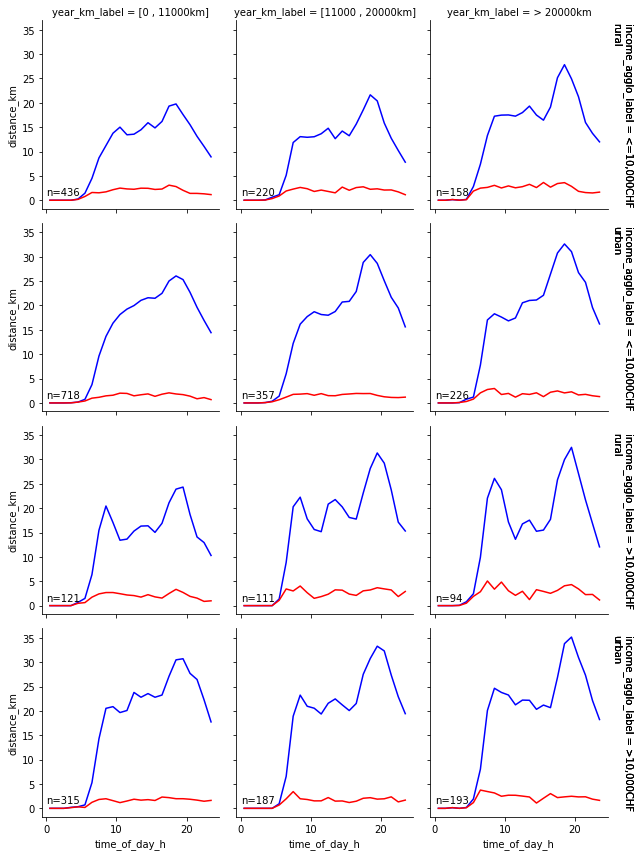

In [41]:
# To get nice plots: order categories in a meaningful way
print("Generating plots...")


def distance_range(r):
    if r.startswith(">"): return float("inf")

    low = re.search("\[(.*),", r).group(1)
    return float(low)

def income_agglo_range(r):
    code = ""
    if r.startswith(">") : code += "1"
    else : code += "0"

    if "urban" in r : code += "1"
    else : code += "0"

    return float(code)

# looks strange, but set cannot get a pandas series in constructor, while list can...
print("Ordering annual km traveled...")
distance_ordered = list(set(list(results_per_group.year_km_label)))
distance_ordered.sort(key=distance_range)
print(distance_ordered)

print("Ordering incomes + agglo types...")
results_per_group['income_agglo_label'] = results_per_group['income_label'].str.cat(results_per_group['agglo_label'], sep='\n')
income_agglo_ordered = list(set(list(results_per_group.income_agglo_label)))
income_agglo_ordered.sort(key=income_agglo_range)
print(income_agglo_ordered)


# Cannot get bloody Seaborn to understand that my "hue" variable should be continuous...
# Dirty hack to get this right
print("Generating figures...")

def create_palette(ns):
    my_palette = {}
    m = np.log(max(ns) + 2)
    all_blues = sns.color_palette("Blues", int(m) + 1)

    for n in ns:
        my_palette[n] = all_blues[int(np.log(n + 1))]

    return my_palette


def annotate(n, **kwargs):
    return plt.annotate("n=" + str(n.iloc[0]), xy=(0, 1))


plt.figure(dpi=120)
grid = sns.FacetGrid(results_per_group,
                     row="income_agglo_label", col="year_km_label", hue="n",
                     row_order=income_agglo_ordered, col_order=distance_ordered,
                     palette=create_palette(results_per_group.n),
                     margin_titles=True)
grid.map(annotate, "n")
grid.map(plt.plot, "time_of_day_h", "driven_time_min", color="b")
grid.map(plt.plot, "time_of_day_h", "distance_km", color="r")